In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from src.data_loader import download_and_extract_data, load_movie_data
from src.collaborative_filtering import SVDRecommender
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1. Load the data
download_and_extract_data()
movies, ratings = load_movie_data()

# 2. Create and train the recommender
recommender = SVDRecommender(ratings, movies)
recommender.fit(k=50) # You can experiment with different values of k

# 3. Get recommendations for a specific user
user_id_to_recommend = 25
recommendations = recommender.recommend(user_id_to_recommend, num_recommendations=10)

print(f"\nTop 10 recommendations for User {user_id_to_recommend}:")
display(recommendations)

MovieLens dataset already exists. Skipping download.
Training the SVD model...
Model training complete.

Top 10 recommendations for User 25:


,movieId,title,genres,prediction
275,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.900478
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.885985
895,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.868214
2220,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.866657
255,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.865983
907,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,4.864226
97,110,Braveheart (1995),Action|Drama|War,4.851467
312,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.851370
656,858,"Godfather, The (1972)",Crime|Drama,4.847034
507,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.843372


In [3]:
# --- 1. Split the data ---
# We split the ratings data into 80% for training and 20% for testing
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Training data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")


# --- 2. Train the model on the TRAINING data only ---
# We use the same SVDRecommender class as before
recommender = SVDRecommender(train_data, movies)
recommender.fit(k=50)


# --- 3. Make predictions on the TEST data ---
# We need a function to get predictions for specific user-movie pairs
def predict_rating(recommender, user_id, movie_id):
    """Predicts a single rating for a user-movie pair."""
    try:
        return recommender.predictions_df.loc[user_id, movie_id]
    except KeyError:
        # Return a default value (e.g., the global mean rating) if user/movie is not in the training set
        return train_data['rating'].mean()

# Apply the prediction function to each row in our test set
test_data['predicted_rating'] = test_data.apply(
    lambda row: predict_rating(recommender, row['userId'], row['movieId']),
    axis=1
)


# --- 4. Calculate the RMSE ---
# Use the mean_squared_error function from scikit-learn
rmse = np.sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))

print(f"\nRoot Mean Squared Error (RMSE) of the model: {rmse:.4f}")

# Display a snippet of the test data with predictions
print("\nTest data with predicted ratings:")
display(test_data.head())

Training data size: 80668
Test data size: 20168
Training the SVD model...
Model training complete.

Root Mean Squared Error (RMSE) of the model: 0.9395

Test data with predicted ratings:


,userId,movieId,rating,timestamp,predicted_rating
67037,432,77866,4.5,1335139641,3.611492
42175,288,474,3.0,978465565,3.084844
93850,599,4351,3.0,1498524542,2.669273
6187,42,2987,4.0,996262677,3.674199
12229,75,1610,4.0,1158989841,3.398608


--- Starting Hyperparameter Tuning ---

Training model with k=20...
Training the SVD model...
Model training complete.
RMSE for k=20: 0.9303

Training model with k=30...
Training the SVD model...
Model training complete.
RMSE for k=30: 0.9330

Training model with k=40...
Training the SVD model...
Model training complete.
RMSE for k=40: 0.9364

Training model with k=50...
Training the SVD model...
Model training complete.
RMSE for k=50: 0.9395

Training model with k=60...
Training the SVD model...
Model training complete.
RMSE for k=60: 0.9416

Training model with k=70...
Training the SVD model...
Model training complete.
RMSE for k=70: 0.9436

--- Tuning Complete ---


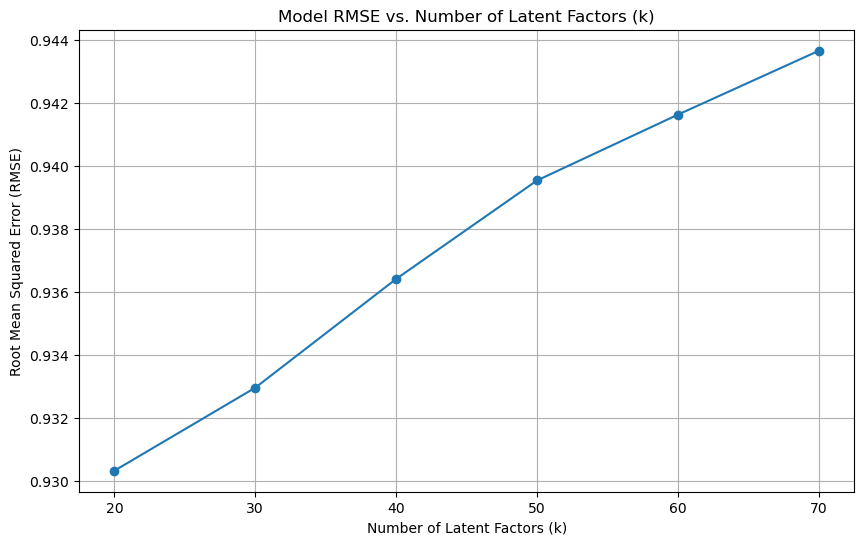

In [7]:
k_values = [20, 30, 40, 50, 60, 70]
rmse_results = []

print("--- Starting Hyperparameter Tuning ---")

for k in k_values:
    print(f"\nTraining model with k={k}...")
    
    # 1. Train the model with the current k
    recommender = SVDRecommender(train_data, movies)
    recommender.fit(k=k)
    
    # 2. Make predictions on the test data
    test_data[f'predicted_rating_k{k}'] = test_data.apply(
        lambda row: predict_rating(recommender, row['userId'], row['movieId']),
        axis=1
    )
    
    # 3. Calculate and store the RMSE
    rmse = np.sqrt(mean_squared_error(test_data['rating'], test_data[f'predicted_rating_k{k}']))
    rmse_results.append(rmse)
    
    print(f"RMSE for k={k}: {rmse:.4f}")

print("\n--- Tuning Complete ---")


# --- 3. Visualize the results ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_results, marker='o', linestyle='-')
plt.title("Model RMSE vs. Number of Latent Factors (k)")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.grid(True)
plt.show()


In [8]:
# After finding the best k (in this case, 20)
best_k = 20

print(f"\n--- Retraining the final model on 100% of the data with k={best_k} ---")

# Use the full 'ratings' DataFrame
final_recommender = SVDRecommender(ratings, movies)
final_recommender.fit(k=best_k)

print("\n--- Final model is ready to make recommendations! ---")

# Now you can use this final_recommender to get predictions for any user
final_recommendations = final_recommender.recommend(user_id=42, num_recommendations=10)

display(final_recommendations)


--- Retraining the final model on 100% of the data with k=20 ---
Training the SVD model...
Model training complete.

--- Final model is ready to make recommendations! ---


,movieId,title,genres,prediction
414,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,4.361392
1843,2858,American Beauty (1999),Drama|Romance,4.351880
764,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.238771
340,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,4.202075
2045,3147,"Green Mile, The (1999)",Crime|Drama,4.141842
773,1208,Apocalypse Now (1979),Action|Drama|War,4.073526
766,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,4.063908
509,778,Trainspotting (1996),Comedy|Crime|Drama,4.053006
423,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.042325
771,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,4.036928
